In [99]:
%%time

# General Modules
import numpy as np
import pandas as pd
from  datetime import datetime as dt

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# For Forecasting
from fbprophet import Prophet

# For Classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

%matplotlib inline

CPU times: user 2.2 ms, sys: 95 µs, total: 2.29 ms
Wall time: 2.27 ms


# Import Datasets
---
## Temperature

In [2]:
dfs = {}
dataName = 'temp'
dfs [dataName] = pd.read_csv ('../data/firstPass/GlobalTemperatures.csv', parse_dates = ['dt'])
dfs [dataName] = dfs [dataName].rename (index = str, columns = {'LandAndOceanAverageTemperature': 'TempGlobal', 'LandAverageTemperature': 'TempLand'})
dfs [dataName]['year'] = pd.DatetimeIndex (dfs [dataName]['dt']).year
dfs [dataName] = dfs [dataName].drop (['dt'], axis = 1)
dfs [dataName] = dfs [dataName].groupby ('year')[['TempGlobal', 'TempLand']].mean ()
dfs [dataName] = dfs [dataName] [dfs [dataName].index > 1899]
dfs [dataName].index = dfs [dataName].index.map (int)
dfs [dataName].sample (5)

,TempGlobal,TempLand
year,,
1994,15.535000,9.038750
1989,15.441583,8.922000
1950,15.139500,8.365250
1992,15.453000,8.836583
1943,15.345000,8.755083


## Natural Disasters

In [3]:
dataName = 'disastor'
dfs [dataName] = pd.read_csv ('../data/catastrophes/disastors.csv', parse_dates = ['Year'])
dfs [dataName] = dfs [dataName].rename (index = str, columns = {'Year': 'year', 'Number of disasters (EMDAT (2017)) (reported disasters)': 'Reports'})
dfs [dataName].index = pd.DatetimeIndex (dfs [dataName]['year']).year
dfs [dataName] = dfs [dataName].drop (['year', 'Code'], axis = 1)
dfs [dataName] = dfs [dataName] [dfs [dataName].index > 1899]
dfs [dataName].index = dfs [dataName].index.map (int)
dfs [dataName].sample (5)

,Entity,Reports
year,,
1960,Extreme weather,20
1951,Extreme weather,11
1932,Earthquake,2
1970,All natural disasters,81
1992,Mass movement (dry),5


### Unique Disaster Events

In [4]:
dfs ['disastor']['Entity'].unique ()

array(['All natural disasters', 'Drought', 'Earthquake', 'Epidemic',
       'Extreme temperature', 'Extreme weather', 'Flood', 'Impact',
       'Landslide', 'Mass movement (dry)', 'Volcanic activity',
       'Wildfire'], dtype=object)

---
### Faceting - Create Separate Dataframes for Each Disaster Event

In [5]:
dataName = 'disastor'
dfPerEntity = {}
entities = dfs [dataName]['Entity'].unique ()

for entity in entities:
    dfPerEntity [entity] = dfs [dataName][dfs [dataName]['Entity'] == entity]

---
## Feature Engineering - Decomposition of Values into Trends and Noise

In [6]:
# Function for decomposing a time-series using EWMA
def decompose (df, column, window = 5, visualize = True):
    ewmaColumn = column + 'Trend'
    noiseColumn = column + 'Noise'
    df [ewmaColumn] = df [column].ewm (com = window).mean ()
    df [noiseColumn] = df [column] - df [ewmaColumn]
    
    if (visualize):
        fig = plt.figure (figsize = (20, 20))
        plt.subplot (3, 1, 1)
        df [column].plot (x = df.index)
        plt.xlabel ('Year', fontsize = 'x-large', fontweight = 'bold')
        plt.ylabel (column, fontsize = 'x-large', fontweight = 'bold')
        plt.xticks (fontweight = 'bold')
        plt.yticks (fontweight = 'bold')
    
        plt.subplot (3, 1, 2)
        df [ewmaColumn].plot (x = df.index)
        plt.xlabel ('Year', fontsize = 'x-large', fontweight = 'bold')
        plt.ylabel ('EWMA (window = %d)' % (window), fontsize = 'x-large', fontweight = 'bold')
        plt.xticks (fontweight = 'bold')
        plt.yticks (fontweight = 'bold')
        
        plt.subplot (3, 1, 3)
        df [noiseColumn].plot (x = df.index)
        plt.xlabel ('Year', fontsize = 'x-large', fontweight = 'bold')
        plt.ylabel ('Noise', fontsize = 'x-large', fontweight = 'bold')
        plt.xticks (fontweight = 'bold')
        plt.yticks (fontweight = 'bold')
        
        plt.suptitle ('\n\nDecomposition of %s\n into Trend and Noise' % (column), fontsize = 'xx-large', fontweight = 'bold')


    return

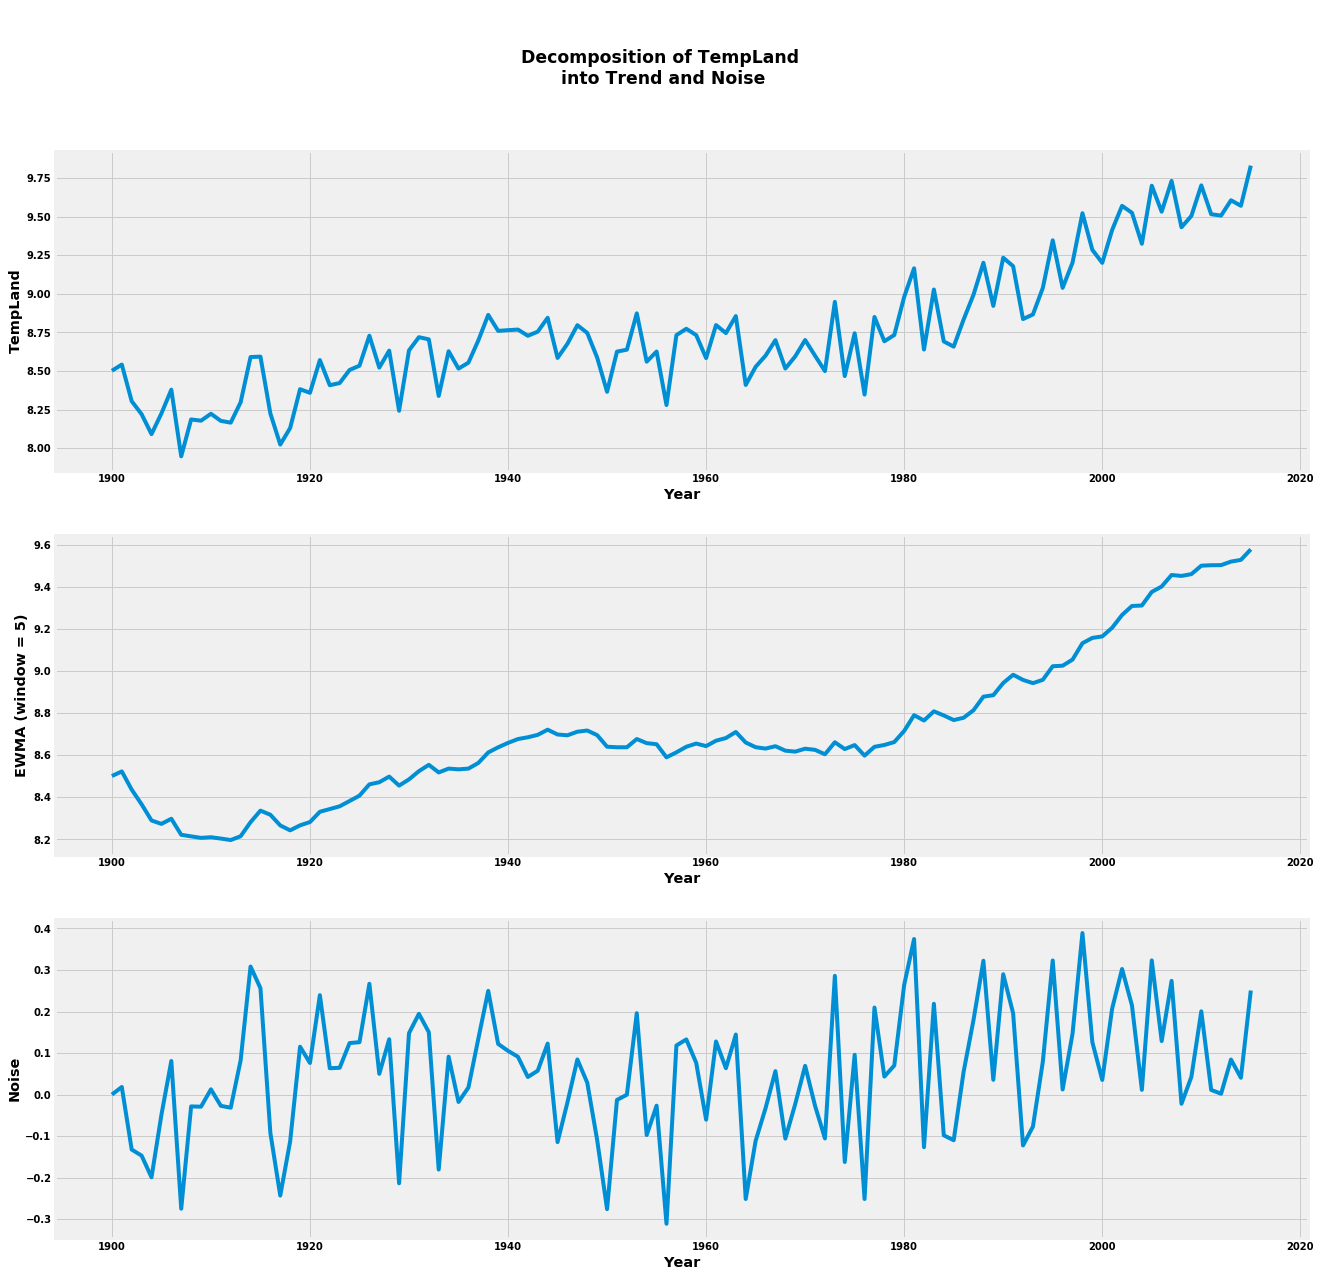

In [7]:
decompose (dfs ['temp'], 'TempLand', visualize = True)

## Dataset Creation - Reported (Unique) Disasters vs Global Temperature Trend
---

In [8]:
# Create a new dataset with temperature as primary feature
def createDataset (decisionName, targetDecisionName, visualize = 'False'):
    tempType = 'TempLand'
    name = targetDecisionName
    datasets [name] = dfPerEntity [decisionName].join (dfs ['temp'], how = 'inner')
    datasets [name] = datasets [name].rename (index = str, columns = {'Reports': targetDecisionName})
    decompose (datasets [name], targetDecisionName, visualize = False)
    decompose (datasets [name], tempType, visualize = False)
    datasets [name] = datasets [name][[targetDecisionName, tempType, targetDecisionName + 'Trend', tempType + 'Trend']]
    
    if (visualize):
        fig = plt.figure (figsize = (20, 20))
        plt.subplot (2, 2, 1)
        xValNames = tempType + 'Trend'
        yValNames = targetDecisionName + 'Trend'
        plt.plot (datasets [name][xValNames], datasets [name][yValNames], '-ko', lw = 0.5)
        plt.xlabel (xValNames, fontsize = 'x-large', fontweight = 'bold')
        plt.ylabel (yValNames, fontsize = 'x-large', fontweight = 'bold')
        plt.xticks (fontweight = 'bold')
        plt.yticks (fontweight = 'bold')
        
        plt.subplot (2, 2, 2)
        xValNames = tempType
        yValNames = targetDecisionName
        plt.plot (datasets [name][xValNames], datasets [name][yValNames], '-r*', lw = 0.5)
        plt.xlabel (xValNames, fontsize = 'x-large', fontweight = 'bold')
        plt.ylabel (yValNames, fontsize = 'x-large', fontweight = 'bold')
        plt.xticks (fontweight = 'bold')
        plt.yticks (fontweight = 'bold')
        
        plt.suptitle ('\n\nComparison of Trends vs Absolute Values\nDataset: (%s vs %s)' % (targetDecisionName, tempType), fontsize = 'xx-large', fontweight = 'bold')
    
    return

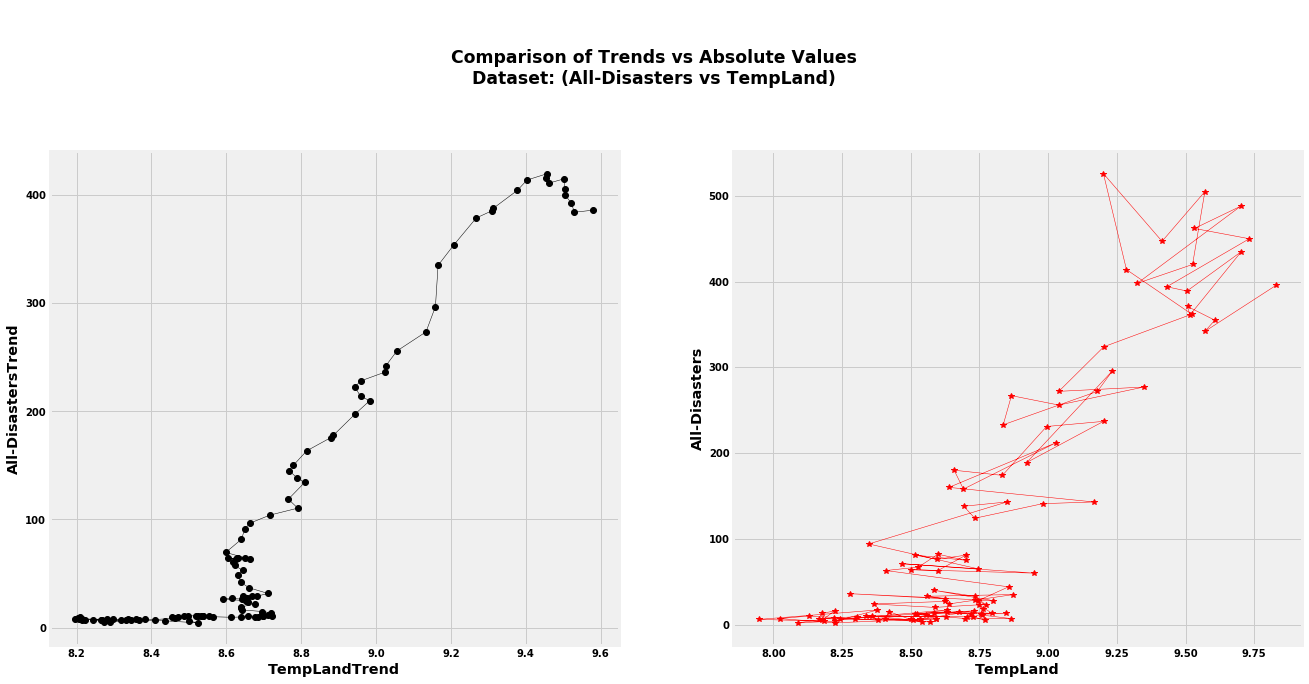

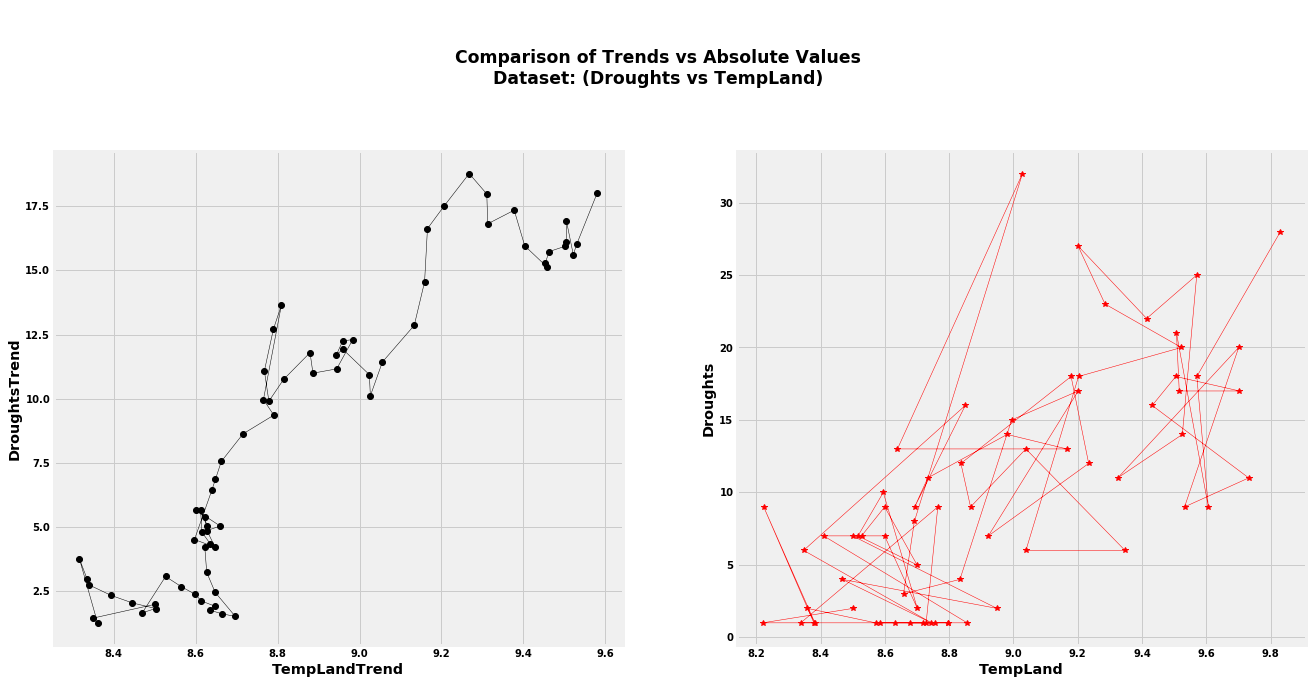

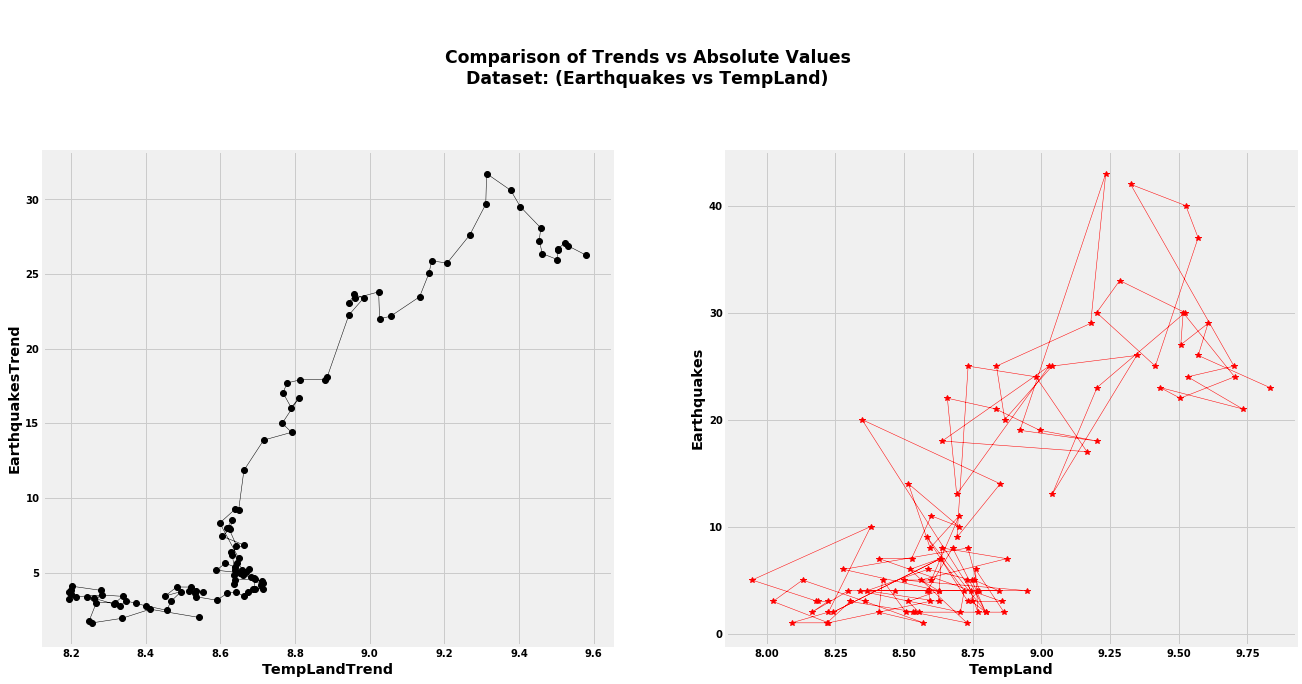

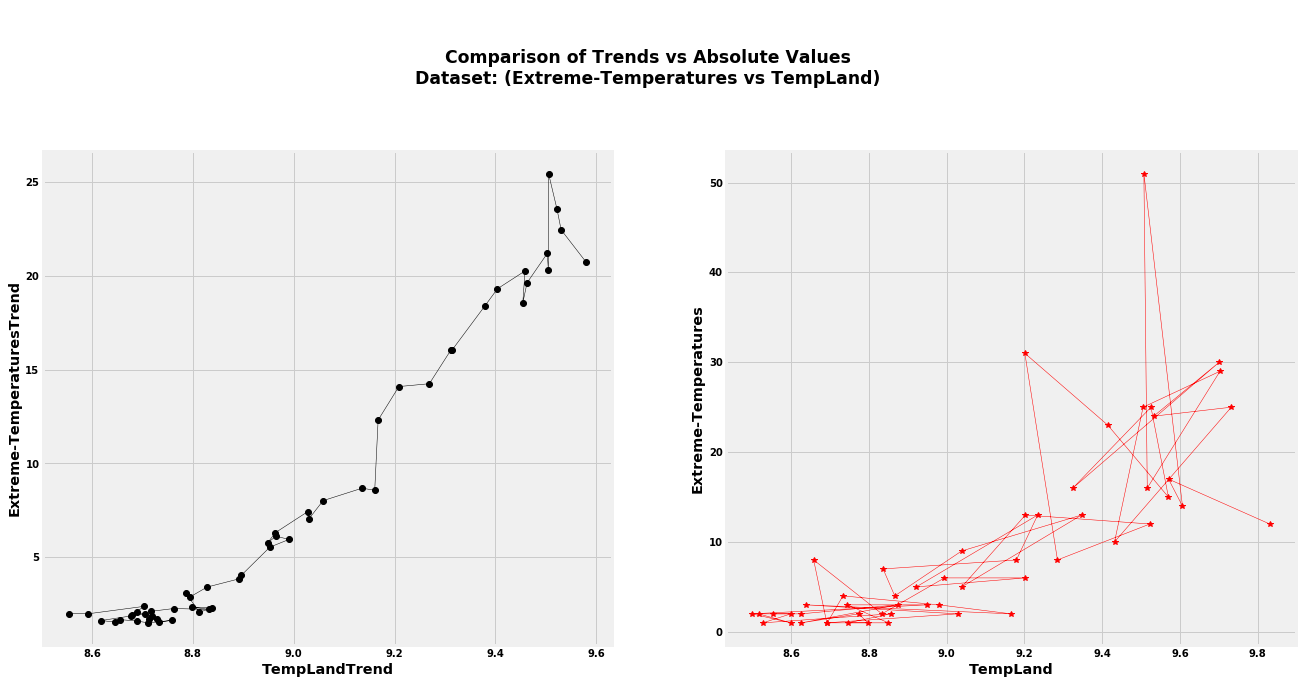

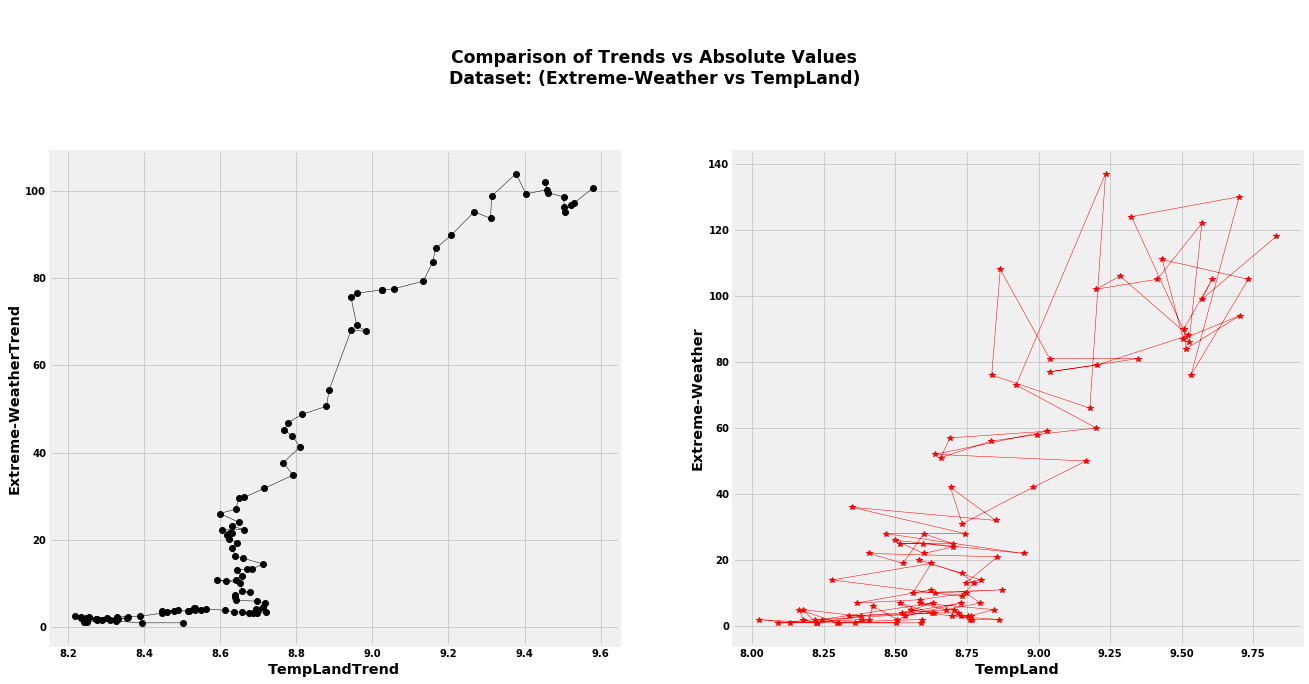

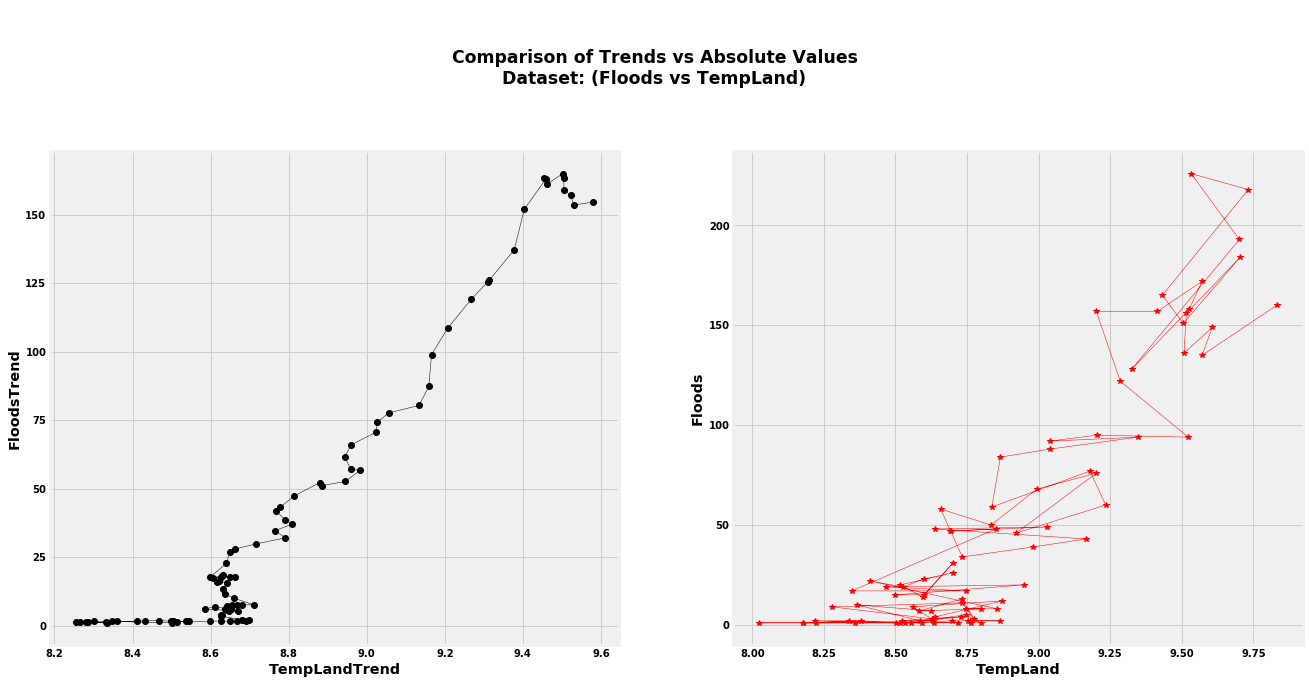

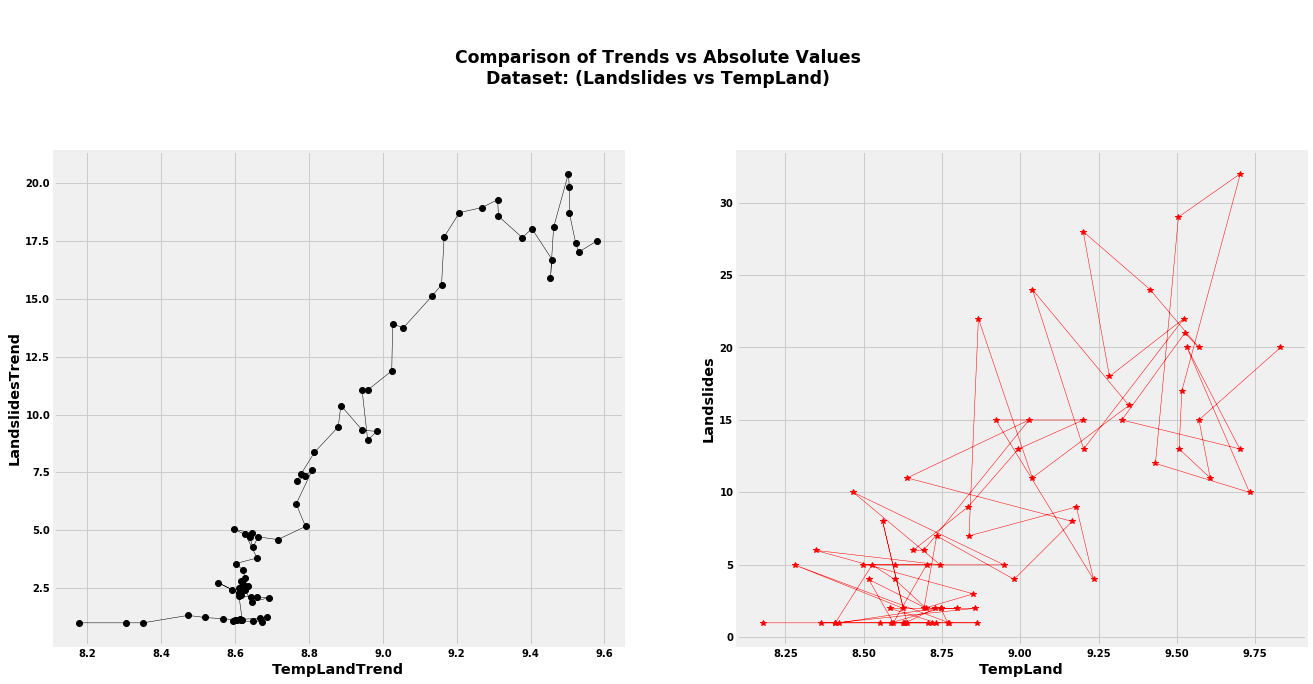

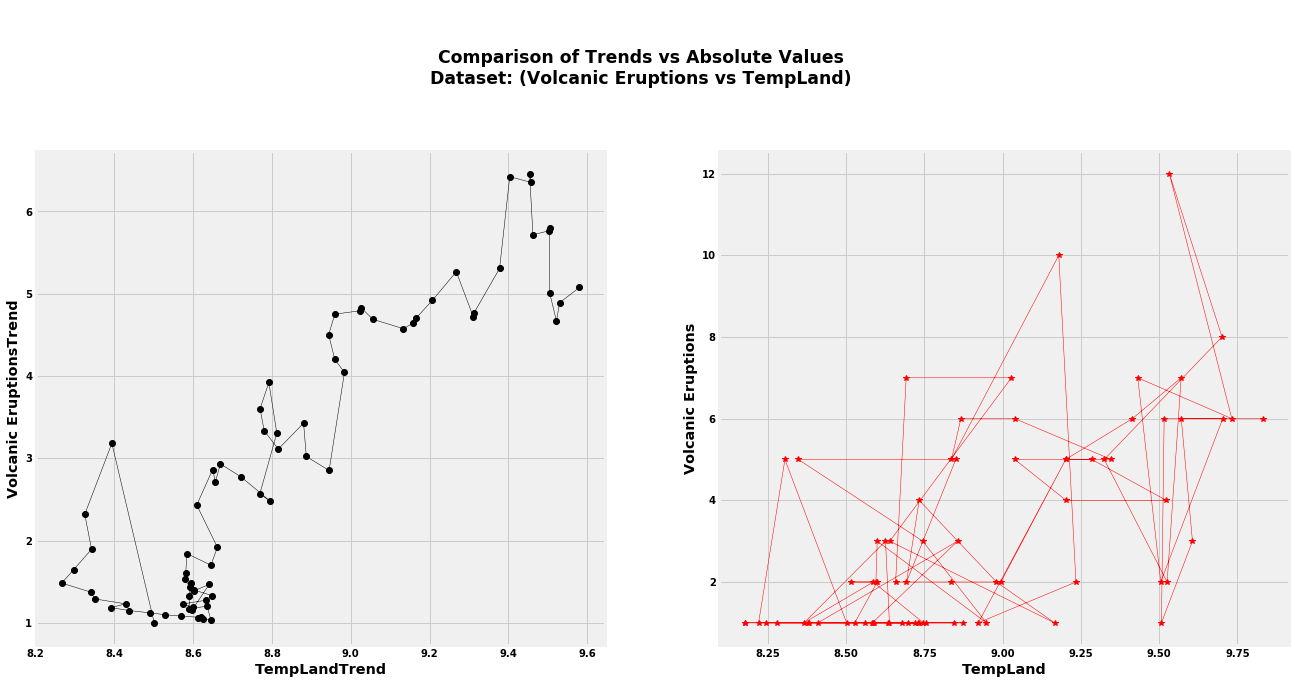

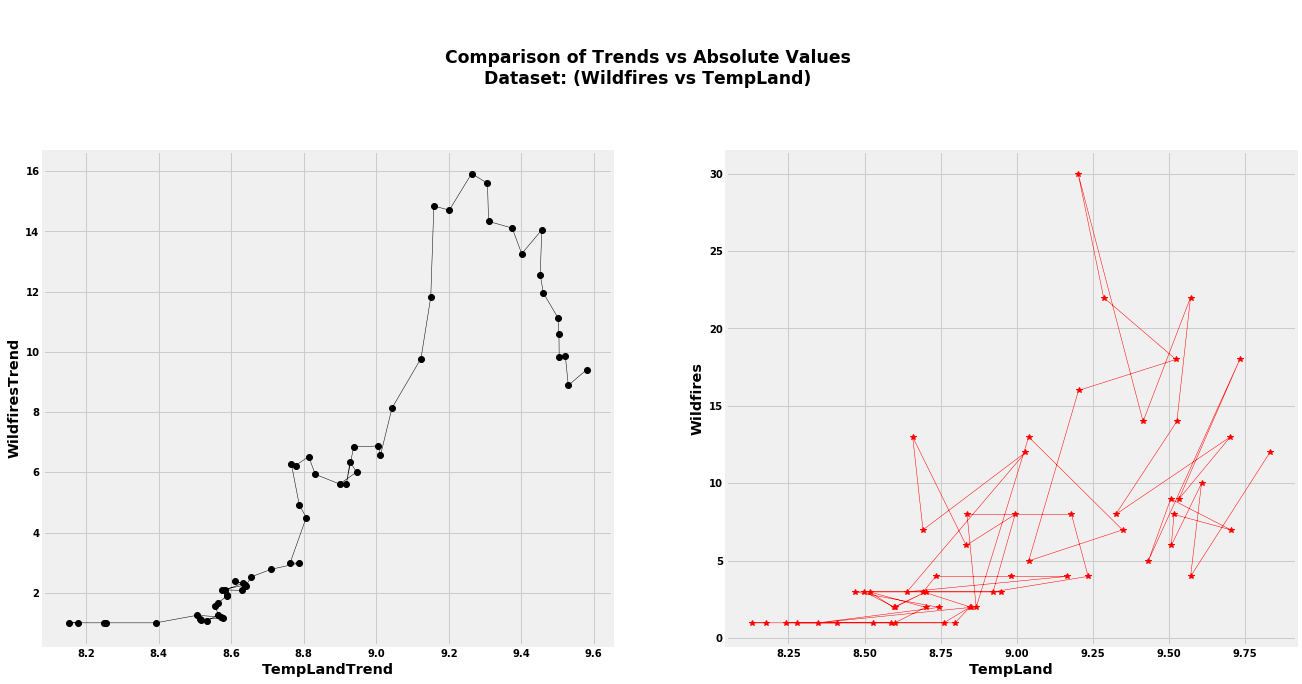

In [9]:
# We are interested in creating following datasets
# TempLand + All Natural Disasters        | tempAlDis
# TempLand + Drought                      | tempDrght
# TempLand + Earthquake                   | tempQuake
# TempLand + Extreme Temperature          | tempExtmp
# TempLand + Extreme Weather              | tempExWth
# TempLand + Flood                        | tempFlood
# TempLand + Landslide                    | tempSlide
# TempLand + Volcanic Activity            | tempVolcn
# TempLand + Wildfires                    | tempWfire

datasets = {}
createDataset ('All natural disasters', 'All-Disasters', visualize = True)
createDataset ('Drought', 'Droughts', visualize = True)
createDataset ('Earthquake', 'Earthquakes', visualize = True)
createDataset ('Extreme temperature', 'Extreme-Temperatures', visualize = True)
createDataset ('Extreme weather', 'Extreme-Weather', visualize = True)
createDataset ('Flood', 'Floods', visualize = True)
createDataset ('Landslide', 'Landslides', visualize = True)
createDataset ('Volcanic activity', 'Volcanic Eruptions', visualize = True)
createDataset ('Wildfire', 'Wildfires', visualize = True)

## Exploration - Trends of Reported Disasters vs Global Temperature
---

In [10]:
import operator

# Lets see how strongly the trend of reported number of disastors
# of each type correlates with the trend of global temperature change
correlDict = {}
for event in datasets.keys ():
    correl = datasets [event]['TempLand'].corr (datasets [event][event])
    correlDict [event] = correl
    print '%20s : ' % (event), correl

sortedCorrel = sorted (correlDict.items (), key = operator.itemgetter (1), reverse = True)

events = []
correlations = []
for obj in sortedCorrel:
    events.append (obj [0])
    correlations.append (obj [1])

           Wildfires :  0.6308312199419812
       All-Disasters :  0.8710904795418017
            Droughts :  0.6976358456698649
Extreme-Temperatures :  0.7593201716769485
          Landslides :  0.7490802636687935
              Floods :  0.8879991413425775
     Extreme-Weather :  0.850458465495283
         Earthquakes :  0.7773736923265995
  Volcanic Eruptions :  0.5998379891865908


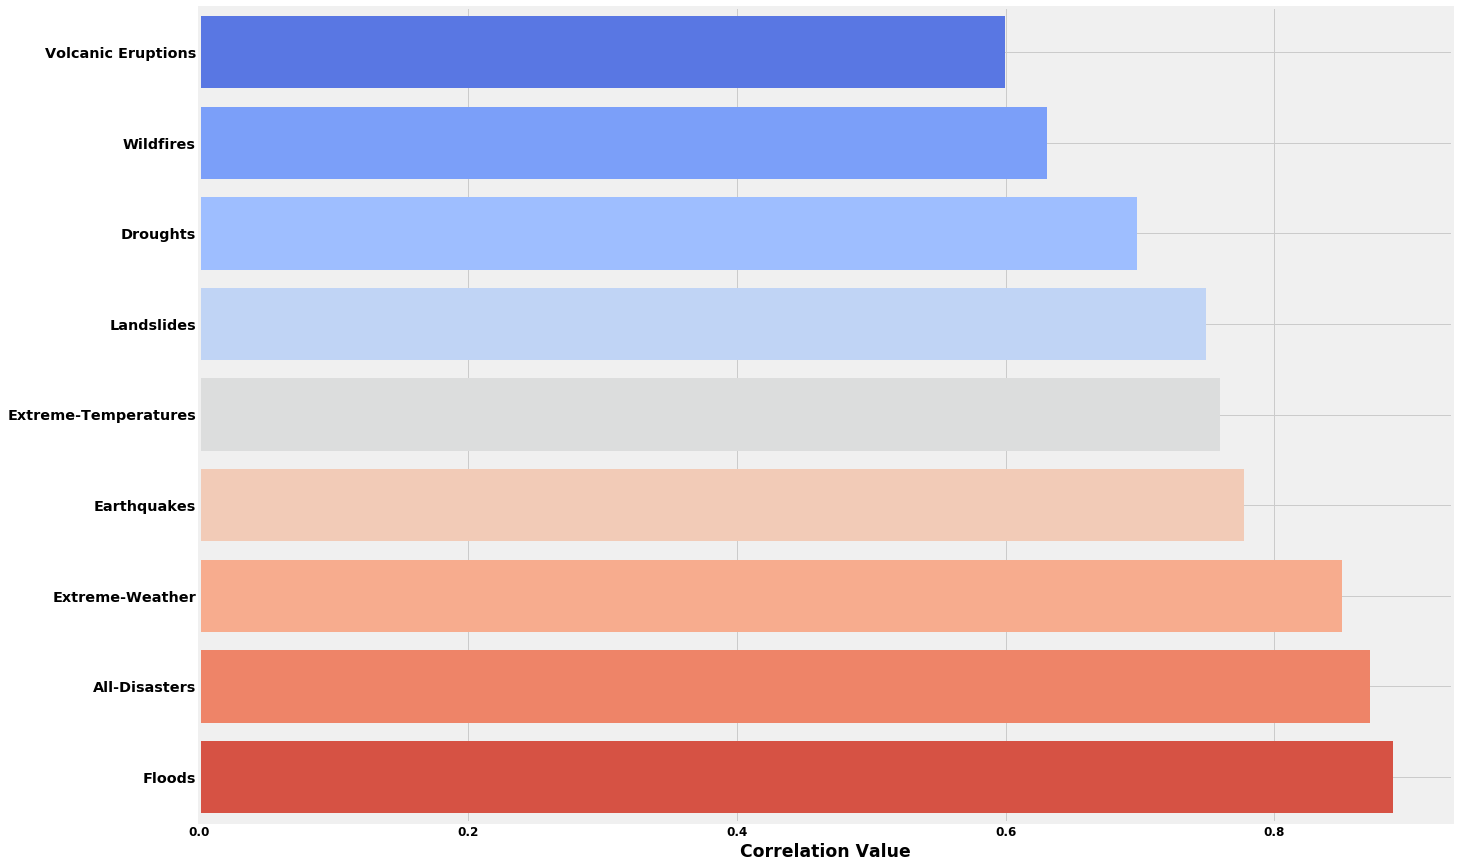

In [11]:
fig = plt.figure (figsize = (20, 15))
plt.barh (range (len (events)), correlations, color = sns.color_palette ("coolwarm_r", len (events)))
plt.ylim (-0.5, len (events) - 0.5)
plt.yticks (range (len (events)), events, fontsize = 'x-large', fontweight = 'bold')
plt.xticks (fontsize = 'large', fontweight = 'bold')
plt.xlabel ('Correlation Value', fontsize = 'xx-large', fontweight = 'bold')
plt.show ()

## Forecasting Future Climate Change
---

In [12]:
# Forecasting global temperature trend

df_flood = datasets ['Floods'][['TempLandTrend']]
df_flood = df_flood.rename (index = str, columns = {'TempLandTrend': 'y'})
df_flood ['ds'] = pd.to_datetime (df_flood.index)

m = Prophet ()
m.fit (df_flood)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(array([ 8. ,  8.5,  9. ,  9.5, 10. , 10.5]),
 <a list of 6 Text yticklabel objects>)

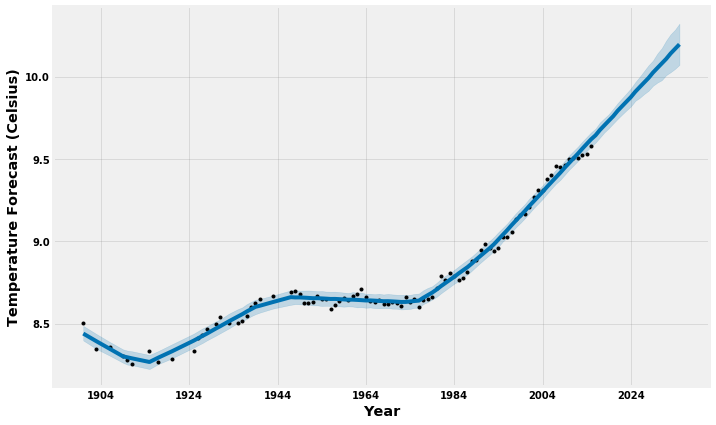

In [13]:
future = m.make_future_dataframe (periods = 20, freq = 'Y')
fcst = m.predict (future)
fig = m.plot (fcst)
plt.xlabel ('Year', fontsize = 'x-large', fontweight = 'bold')
plt.ylabel ('Temperature Forecast (Celsius)', fontsize = 'x-large', fontweight = 'bold')
plt.xticks (fontweight = 'bold')
plt.yticks (fontweight = 'bold')

## Disaster Forecast based on Climate Change Forecast
---

In [35]:
pd.options.mode.chained_assignment = None

# Forecast flood events in the future based on Temperature Predictions
df_predFlood = fcst [['yhat']]
df_predFlood.index = pd.DatetimeIndex (fcst ['ds']).year
df_predFlood.index.names = ['year']
df_predFlood = df_predFlood.rename (index = str, columns = {'yhat': 'TempLandTrend'})

df_clFlood = datasets ['Floods'][['FloodsTrend']]

# We are doing outer join here; so that we may keep forecasted
# temperature values
df_predFlood = df_predFlood.join (df_clFlood, how = 'outer')

In [169]:
# The last 20 entries of temperature dataset are forecasts given by FB-Prophet.
# Our training dataset contains the actually reported temperature values. Our
# aim is to predict unknown disaster values based on forecasted temperatures
df_train = df_predFlood.iloc [:-20]
df_train ['Floods'] = df_train.FloodsTrend.map (int)
df_train ['EarthquakesTrend'] = datasets ['Earthquakes']['EarthquakesTrend']
df_train ['Extreme-TemperaturesTrend'] = datasets ['Extreme-Temperatures']['Extreme-TemperaturesTrend']
df_train ['Extreme-WeatherTrend'] = datasets ['Extreme-Weather']['Extreme-WeatherTrend']
df_train = df_train.fillna (method = 'bfill')
df_train.describe ()

,TempLandTrend,FloodsTrend,Floods,EarthquakesTrend,Extreme-TemperaturesTrend,Extreme-WeatherTrend
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,8.785334,41.411322,40.923913,12.164001,5.514897,36.180504
std,0.342708,52.791196,52.773044,9.614947,6.545839,35.873891
min,8.266933,1.000000,1.000000,1.934066,1.516219,1.000000
25%,8.631491,1.762206,1.000000,4.136820,1.990325,4.621399
50%,8.653811,16.813572,16.500000,6.834160,2.000000,21.339853
75%,8.963756,58.189353,58.000000,22.455543,5.999661,70.759512
max,9.619816,165.064733,165.000000,31.733194,25.432724,103.918185


In [170]:
# Equal Width / Interval Discretization
buckets = 15
df_train ['FloodBins'] = pd.cut (df_train ['Floods'], buckets, labels = ['B-%d' % b for b in range (buckets)])
df_train.tail ()

,TempLandTrend,FloodsTrend,Floods,EarthquakesTrend,Extreme-TemperaturesTrend,Extreme-WeatherTrend,FloodBins
year,,,,,,,
2011,9.503737,163.553944,163,26.644950,20.318707,96.162887,B-14
2012,9.532093,158.961620,158,26.704125,25.432724,95.135739,B-14
2013,9.562531,157.301350,157,27.086771,23.527125,96.779782,B-14
2014,9.591270,153.584458,153,26.905642,22.439201,97.149819,B-13
2015,9.619816,154.653715,154,26.254702,20.699242,100.624849,B-13


In [212]:
features = df_train [['TempLandTrend', 'EarthquakesTrend', 'Extreme-TemperaturesTrend', 'Extreme-WeatherTrend']]
labels = df_train.FloodBins

X_train, X_test, y_train, y_test = train_test_split (features, labels, test_size = 0.30, random_state = 0)

[MNB] Score: 0.643


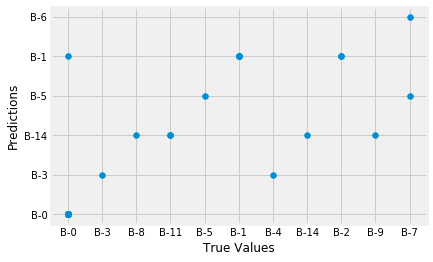

In [213]:
classifier = 'MNB'

m = MultinomialNB ().fit (features, labels)
print '[%s] Score:' % (classifier), round (m.score (X_test, y_test), 3)

predictions = m.predict (X_test)
plt.scatter (y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show ()

[SVC] Score: 0.679


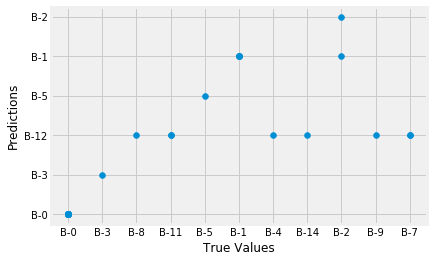

In [214]:
classifier = 'SVC'

m = LinearSVC ().fit (features, labels)
print '[%s] Score:' % (classifier), round (m.score (X_test, y_test), 3)

predictions = m.predict (X_test)
plt.scatter (y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show ()

[LGR] Score: 0.75


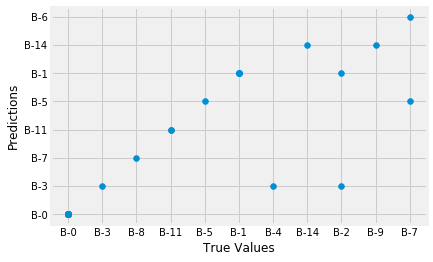

In [215]:
classifier = 'LGR'

m = LogisticRegression ().fit (features, labels)
print '[%s] Score:' % (classifier), round (m.score (X_test, y_test), 3)

predictions = m.predict (X_test)
plt.scatter (y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show ()

[RFC] Score: 0.929


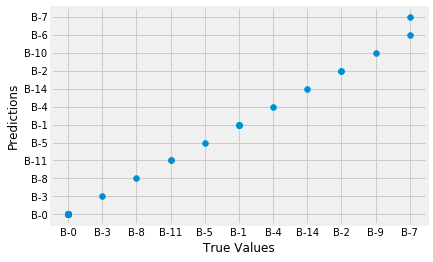

In [217]:
classifier = 'RFC'

m = RandomForestClassifier (n_estimators = 4, n_jobs = 4, random_state = 0).fit (features, labels)
print '[%s] Score:' % (classifier), round (m.score (X_test, y_test), 3)

predictions = m.predict (X_test)
plt.scatter (y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show ()